# Graph Attention Networks

Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio *ICLR 2018*

https://arxiv.org/pdf/1710.10903.pdf

In [1]:
import random

from typing import Dict
from typing import List

import numpy as np
import tensorflow as tf

from IPython.display import Image

## 0 Setup Sample Examples

Following are dummy examples that each example defines a graph with multiple nodes and edges. The nodes are represented by integer ids. The edges (relations) are represented by squared matrix.

In [2]:
BATCH_SIZE = 4

sample_nodes = []
sample_edges = []

for i in range(BATCH_SIZE):
    # Let's assume each graph has at least 3 nodes and no more than 8 nodes.
    num_nodes = random.randint(3, 8)
    
    nodes = random.sample(range(1, 11), num_nodes)
    sample_nodes.append(np.array(nodes))
    
    edges = [[0 for i in range(num_nodes)] for j in range(num_nodes)]
    for j in range(num_nodes):
        for k in range(j+1):
            p = 1 if j == k else 0.4
            edges[j][k] = np.random.binomial(1, p)
            edges[k][j] = edges[j][k]
    sample_edges.append(np.array(edges))
    
for i in range(BATCH_SIZE):
    print("Nodes: ", sample_nodes[i])
    print("Adjacency matrix:")
    print(np.matrix(sample_edges[i]))
    print("")

Nodes:  [1 9 6]
Adjacency matrix:
[[1 0 1]
 [0 1 0]
 [1 0 1]]

Nodes:  [10  4  5]
Adjacency matrix:
[[1 1 0]
 [1 1 0]
 [0 0 1]]

Nodes:  [10  6  4  8  1]
Adjacency matrix:
[[1 1 1 0 0]
 [1 1 0 1 1]
 [1 0 1 1 1]
 [0 1 1 1 0]
 [0 1 1 0 1]]

Nodes:  [ 3  1 10]
Adjacency matrix:
[[1 0 1]
 [0 1 0]
 [1 0 1]]



### Padding

Pad the nodes by 0 and the adjacency matrices

In [3]:
def padding(nodes: List[int], 
            edges: List[List[int]]):
    max_num_nodes = max([len(x) for x in nodes])
    padded_nodes = tf.keras.preprocessing.sequence.pad_sequences(nodes, 
                                                                 padding="post")
    padded_edges = []
    for edge in edges:
        padded_edge = np.zeros([max_num_nodes, max_num_nodes])
        num_nodes = len(edge)
        padded_edge[:num_nodes, :num_nodes] = edge
        padded_edges.append(padded_edge)
        
    return padded_nodes, padded_edges

In [4]:
input_nodes, input_edges = padding(sample_nodes, sample_edges)
for i in range(BATCH_SIZE):
    print("Nodes: ", input_nodes[i])
    print("Adjacency matrix:")
    print(np.matrix(input_edges[i]))
    print("")

Nodes:  [1 9 6 0 0]
Adjacency matrix:
[[1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Nodes:  [10  4  5  0  0]
Adjacency matrix:
[[1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

Nodes:  [10  6  4  8  1]
Adjacency matrix:
[[1. 1. 1. 0. 0.]
 [1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1.]
 [0. 1. 1. 1. 0.]
 [0. 1. 1. 0. 1.]]

Nodes:  [ 3  1 10  0  0]
Adjacency matrix:
[[1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]



### Create tfDataset

In [5]:
BUFFER_SIZE = 4
dataset = tf.data.Dataset.from_tensor_slices((input_nodes, input_edges))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
input_nodes, input_edges = next(iter(dataset))

## Abstract

The paper proposes an architecturethat operates on graph-sturctured data, leveraging masked self-attentional layers to address the shortcomings of prior methods based on graph convolutions or their approximations. 
- allows nodes to attend over their nieghborhoods' features.
- requires no costly matrix operations (such as inversion).
- doesn't depend on knowing the graph structure upfront.

## 1 Introduction & Background

CNNs have been successfully applied to tackle problems where the underlying data representation has a grid-like structure. However this is not always true, in many cases data can usually be represented in the form of graphs.

There have been several attempts to extend the networks to dea with arbitrarily structured graphs.
- [A New Model for Learning in Graph Domains](https://www.researchgate.net/profile/Franco-Scarselli/publication/4202380_A_new_model_for_earning_in_raph_domains/links/0c9605188cd580504f000000/A-new-model-for-earning-in-raph-domains.pdf) Marco Gori, Gabriele Monfardini, Franco Scarselli `IJCNN 2005` **Graph Neural Networks (GNNS)**
- [The graph neural network model](http://persagen.com/files/misc/scarselli2009graph.pdf) Franco Scarselli, Marco Gori, Ah Chung Tsoi, Markus Hagenbuchner, and Gabriele Monfardini `TNNLS 2009` A generalization of RNNs that can direcly deal with a more general class of graphs.
- [Gated Graph Sequence Neural Networks](https://arxiv.org/pdf/1511.05493.pdf) Yujia Li, Daniel Tarlow, Marc Brockschmidt, Richard Zemel `ICLR 2016` propose to use GRUs.

Nevertheless, there is an increasing interest in generalizing convolutions to the graph domain. Advances in this direction are often categorized as **spectral approaches** and **non-spectral approaches**.

 - **Spectral Approaches**: 
     - [Spectral Networks and Locally Connected Networks on Graphs](https://arxiv.org/pdf/1312.6203.pdf) Joan Bruna, Wojciech Zaremba, Arthur Szlam, Yann LeCun `ICLR 2014`
         - Convolution operation is defined in Fourier domain by computing the eigendecomposition of the graph Laplacian.
         - Potentially intense computations and non-spatially localized filters
     - [Deep convolutional networks on graph-structured data](https://arxiv.org/abs/1506.05163) Mikael Henaff, Joan Bruna, Yann LeCun 
         - Introduced a parameterization of spectral filters with smooth coefficients to make them spatially localized.
     - [Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering](https://arxiv.org/pdf/1606.09375.pdf) Michaël Defferrard, Xavier Bresson and Pierre Vandergheynst `NIPS 2016`
         - Approximate the filters by means of a Chebyshev expansion of the graph Laplacian, removing the need to compute the eigenvectors of the Laplacian.
         - yielding spatially localized filters.
     - [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf) Thomas N. Kipf, Max Welling `ICLR 2017`
         - simplified the previous method by restricting the filters to operate in a 1-step neighborhood around each node.

However all these approaches depend on seen & fixed graph structure.

 - **Non-spectral Approaches**
     - Define convolutions directly on the graph, operating on groups of spatially close neighbors. One of the challenges of these approaches is to define an operator which works with different sized neighborhoods and maintains the weight sharing property of CNNs.
         - [Convolutional Networks on Graphs for Learning Molecular Fingerprints](https://papers.nips.cc/paper/2015/file/f9be311e65d81a9ad8150a60844bb94c-Paper.pdf) David K. Duvenaud, Dougal Maclaurin, Jorge Iparraguirre, Rafael Bombarell, Timothy Hirzel, Alan Aspuru-Guzik, Ryan P. Adams `NIPS 2015`
         - [Diffusion-Convolutional Neural Networks](https://papers.nips.cc/paper/2016/file/390e982518a50e280d8e2b535462ec1f-Paper.pdf) James Atwood, Don Towsley `NIPS 2016`
         - [Inductive Representation Learning on Large Graphs](https://papers.nips.cc/paper/2017/file/5dd9db5e033da9c6fb5ba83c7a7ebea9-Paper.pdf) Will Hamilton, Zhitao Ying, Jure Leskovec `NIPS 2017`
     - [Inductive Representation Learning on Large Graphs](https://arxiv.org/pdf/1706.02216.pdf) William L. Hamilton, Rex Ying, Jure Leskovec `NIPS 2017` introduced **GraphSAGE**
         - Computes node representations in an inductive manner. 
         - Operates by sampling a fixed-size neighborhood of each node, and then performing a specific aggregator over it.
         
Inspired by **attention mechanisms**, the paper introduce an architecture to perform node classification of graph-structured data. The idea is to ***compute the hidden representations of each node in the
graph, by attending over its neighbors, following a self-attention strategy***. The attention architecture
has several interesting properties:
- the operation is efficient, since it is parallelizable across nodeneighbor pairs.
- it can be applied to graph nodes having different degrees by specifying arbitrary
weights to the neighbors
- the model is directly applicable to inductive learning problems,

## 2 Model Architecture

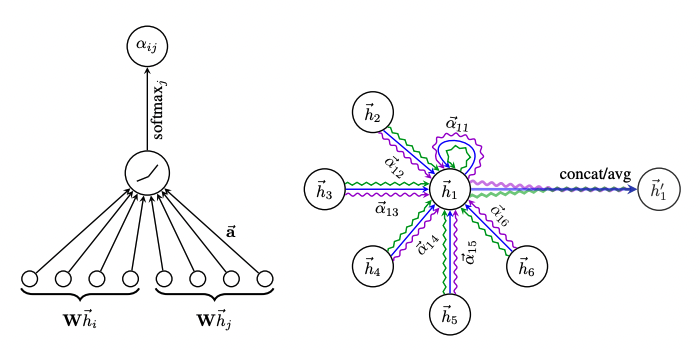

In [6]:
Image(filename='../pics/graph_attention.png')

### 2.1 Graph Attentional Layer

The input to this layer is a set of node features 

$$h = \{h_1, h_2, ..., h_N\}, h_i \in R^F$$

Where $N$ is the number of nodes, and $F$ is the number of features in each node (dimensionality of embedding)

The layer produces a new set of node features (of potentially different cardinality $F^\prime$)

$$h = \{h_1^\prime, h_2^\prime, ..., h_N^\prime\}, h_i^\prime \in R^{F^\prime}$$

The model allows every node to attend on every other node. The graph structure is injected into the mechanism by the masks. The attentions for node $i$ are only counted for nodes $j \in N_i$ where $N_i$ is some neighborhood of node $i$ in the graph.

- **Score** query (node $i$) and key (the other node $j$) in additive manner, the same set of weights are shared by both nodes.

$$e_{ij}=LeakyReLU([Wh_i, Wh_j])$$

- **Alighment** with softmax to get attention weights

$$\alpha_{ij}=\frac{\exp(e_{ij})}{\sum_{k \in N_i}\exp(e_{ik})}$$

- **Calcualte Attention** for a node as weighted sum of all its neighbors, and used as its encodings.

$$h_i^\prime = \sum_{j \in N_i}\alpha_{ij}Wh_j$$

Like the **Transformer** model, if perform multi-headed attention, an **averaging** is employed to get the aggregated encodings. Different from the transformer model where the input tensors are splitted into multi-heads, here it makes multiple replicates of original input tensors. 

$$h_i^\prime = \frac{1}{K}\sum_{k=1}^K\sum_{j \in N_i}\alpha_{ij}^kW_kh_j$$

In [7]:
class MultiHeadedGraphAttention(tf.keras.layers.Layer):
    """ Multi-Headed Graph Attention Layer
    
    Args:
        num_heads: Number of heads to split into.
        hidden_size: Dimensionality of the hidden layers.
    Inputs:
        inputs: A dict of tensor:
            - nodes: shape of (batch_size, num_nodes, emb_size)
            - mask: shape of (batch_size, num_nodes, num_nodes)
    Returns:
        node_encodings: of shape (batch_size, num_nodes, hidden_size)
    """
    def __init__(self, 
                 num_heads: int, 
                 hidden_size: int, 
                 name: str="graph_attention_layer"):
        super(MultiHeadedGraphAttention, self).__init__(name=name)
        self.num_heads = tf.cast(num_heads, tf.int32)
        self.hidden_size = tf.cast(hidden_size, tf.int32)

        self.node_linear = tf.keras.layers.Dense(units=hidden_size, use_bias=False)
        self.score_linear = tf.keras.layers.Dense(units=1, use_bias=False)
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
        
    
    def graph_attention(self, 
                        query: tf.Tensor, 
                        key: tf.Tensor, 
                        mask: tf.Tensor):
        num_nodes = tf.shape(query)[2]
        
        # Attention - Score
        #   Calcualte score of shape (batch_size, num_heads, num_nodes*num_nodes, 1)
        q = tf.repeat(query, repeats=num_nodes, axis=2)
        k = tf.tile(key, [1, 1, num_nodes, 1])
        score = tf.concat([q, k], axis=3)
        score = self.score_linear(score)
        
        # Attention - Alignment
        #   Apply LeakyReLU
        logits = self.leaky_relu(score)
        #   Softmax on the third axis (num_heads*num_heads), so they add up to 1. 
        #   (batch_size, num_heads, num_nodes*num_nodes, 1)
        attention_weights = tf.nn.softmax(logits, axis=2)
        #   Reshape the tensor to (batch_size, num_heads, num_nodes, num_nodes)
        attention_weights = tf.reshape(attention_weights, 
                                       shape=[-1, self.num_heads, num_nodes, num_nodes])
        
        # Attention - Calcualte context vector (encodings) 
        #   Mask out the paddings and non-neighbors (batch_size, num_heads, num_nodes, num_nodes)
        mask = tf.expand_dims(mask, axis=1)
        attention_weights *= tf.cast(mask, tf.float32)
        #   Calculate context vector of shape (batch_size, num_heads, num_nodes, hidden_size)
        context_vector = tf.matmul(attention_weights, key)
        
        return context_vector, attention_weights


    def call(self, inputs: Dict[str, tf.Tensor]) -> tf.Tensor:
        nodes = inputs["nodes"]
        mask = inputs["edge_mask"]
        
        # Linear transformation (batch_size, num_nodes, hidden_size)
        nodes = self.node_linear(nodes)
        
        # Make replicates for multi-headed attention. This is different from the 
        # Transformer paper, which splits the tensor.
        # (batch_size, num_heads, num_nodes, hidden_size)
        nodes = tf.expand_dims(nodes, axis=1)
        nodes = tf.repeat(nodes, repeats=[self.num_heads], axis=1)
        
        # Get the encoded nodes of shape (batch_size, num_heads, num_nodes, hidden_size)
        # And the attention_weights of shape (batch_size, num_heads, num_nodes, num_nodes)
        node_encodings, attention_weights = self.graph_attention(query=nodes, key=nodes, mask=mask)
        
        # Aggregate the multi-headed attention by averaging.
        # (batch_size, num_nodes, hidden_size)
        node_encodings = tf.reduce_mean(node_encodings, axis=1)
        
        return node_encodings

### 2.2 Encoder

In [8]:
def Encoder(num_layers: int, 
            num_heads: int, 
            max_num_nodes: int, 
            emb_size: int,
            hidden_size: int, 
            name="encoder"):
    """Graph Attention Encoder.
    
    Args:
        num_layers: Number of graph attention layers.
        num_heads: Number of heads for multi-headed attention.
        max_num_nodes: Maximum number of nodes in the graph.
        emb_size: Dimensinality of embeddings.
        hidden_size: Dimensionality of the hidden layers.
        name: Name of the Encoder.
    Inputs:
        nodes: Indices of input nodes, of shape (batch_size, max_num_nodes)
        edges: Ajacency matrix, of shape (batch_size, max_num_nodes, max_num_nodes)
    Returns:
        node_encodings: Encoded nodes, of shape (batch_size, max_num_nodes, hidden_size)
    """
    nodes = tf.keras.Input(shape=(max_num_nodes))
    mask = tf.keras.Input(shape=(max_num_nodes, max_num_nodes))
    
    embedding_layer = tf.keras.layers.Embedding(input_dim=max_num_nodes, 
                                                output_dim=emb_size)
    attention_layers = [MultiHeadedGraphAttention(num_heads=num_heads,
                                                  hidden_size=hidden_size, 
                                                  name="graph_attention_layer"+str(i))
                        for i in range(num_layers)]
    
    # Embedding layer
    embeddings = embedding_layer(nodes)
    
    # Stacked graph attention layers
    encodings = embeddings
    for attention_layer in attention_layers:
        encodings = attention_layer({"nodes": encodings, "edge_mask": mask})
    
    return tf.keras.Model(inputs=[nodes, mask], outputs=encodings, name=name)

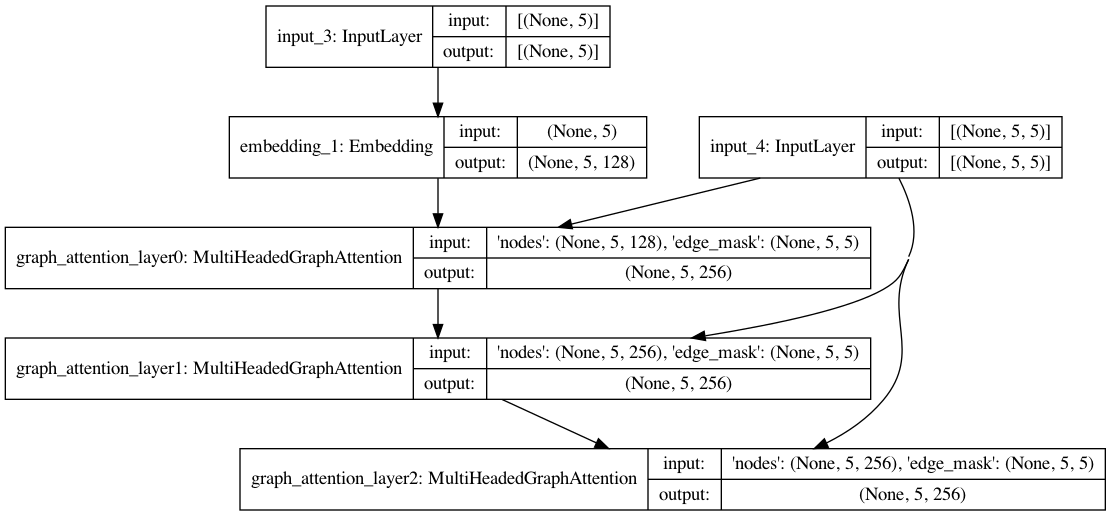

In [10]:
# Example
NUM_LAYERS = 3
NUM_HEADS = 6
MAX_NUM_NODES = input_nodes.shape[1]
EMB_SIZE = 128
HIDDEN_SIZE = 256
encoder = Encoder(num_layers=NUM_LAYERS, 
                  num_heads=NUM_HEADS, 
                  max_num_nodes=MAX_NUM_NODES, 
                  emb_size=EMB_SIZE,
                  hidden_size=HIDDEN_SIZE)
tf.keras.utils.plot_model(encoder, show_shapes=True)